In [1]:
# Import the libraries
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.classification import GBTClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder, StandardScaler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.sql import SparkSession
from pyspark.ml.feature import Bucketizer
from pyspark.mllib.stat import Statistics
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_columns', None)

In [2]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [3]:
spark_df = spark.read.csv('./healthcare-dataset-stroke-data.csv', inferSchema=True, header=True)

In [4]:
#First Look..
spark_df.show(5)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

In [5]:
#Info() as pandas....
spark_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



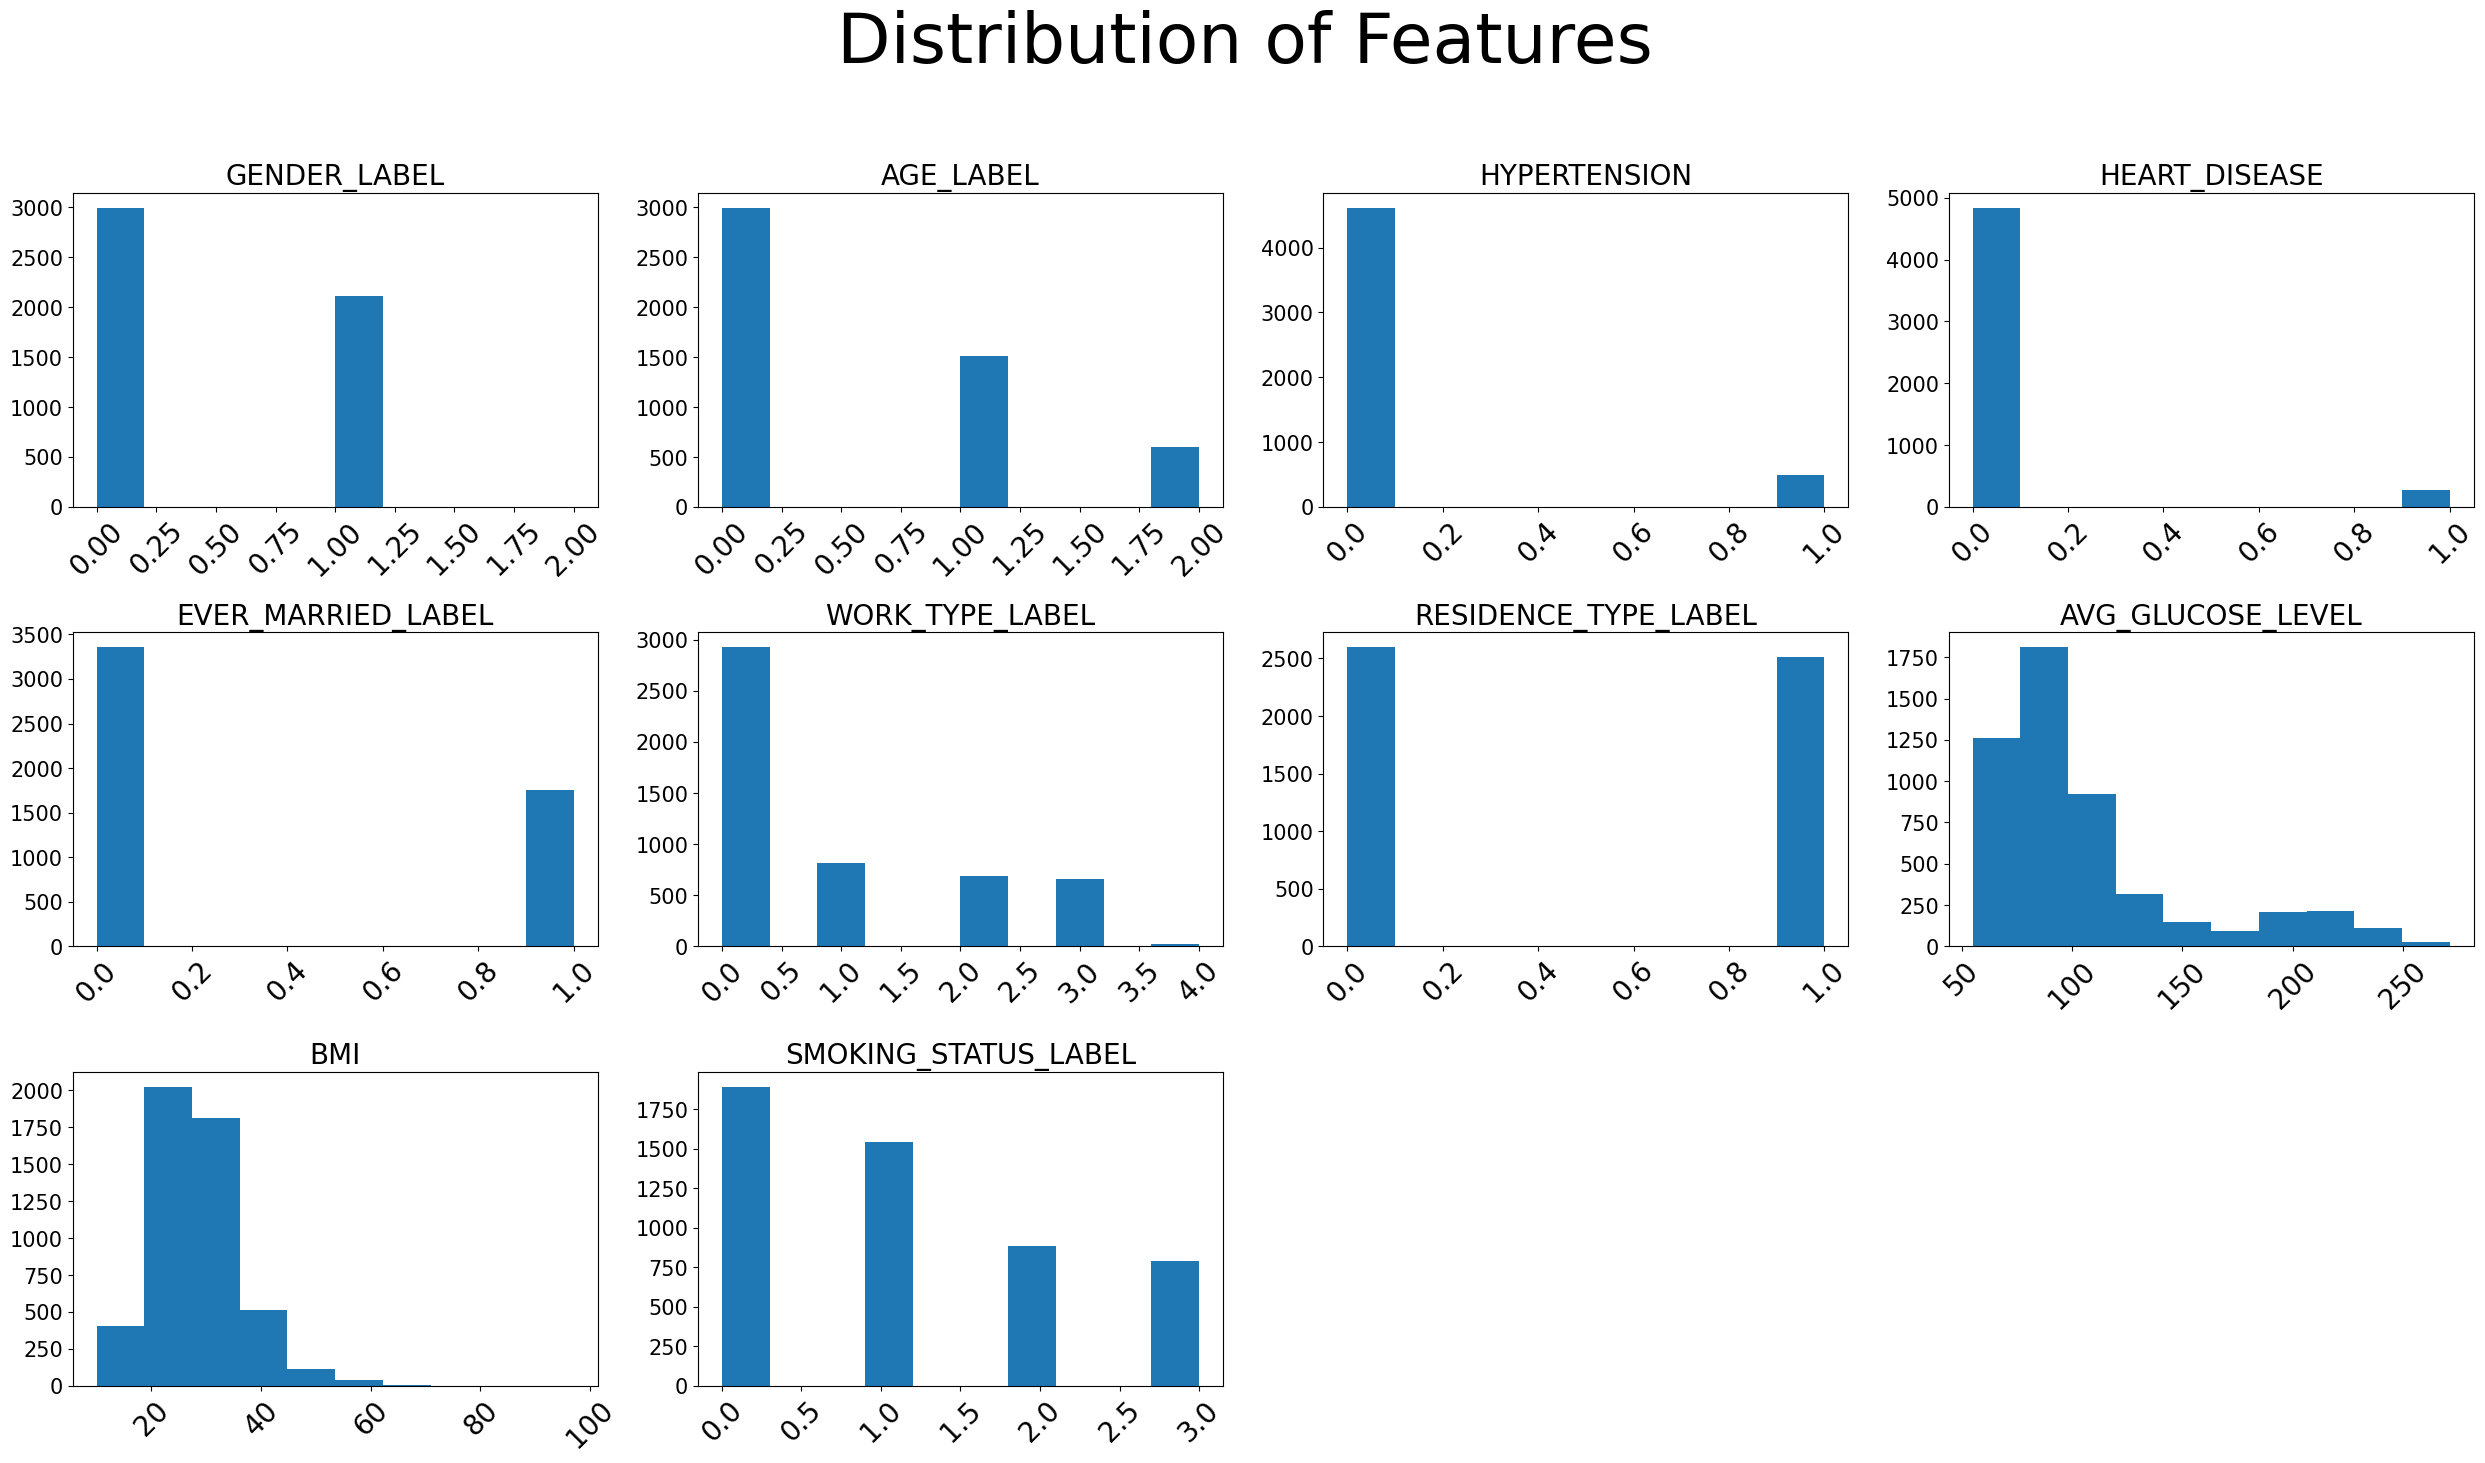

In [36]:
fig = plt.figure(figsize=(25, 15))
st = fig.suptitle("Distribution of Features", fontsize=50, verticalalignment="center")
for col, num in zip(spark_df.toPandas().describe().columns, range(1,11)):
  ax = fig.add_subplot(3,4, num)
  ax.hist(spark_df.toPandas()[col])
  plt.grid(False)
  plt.xticks(rotation=45, fontsize=20)
  plt.yticks(fontsize=15)
  plt.title(col.upper(), fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85, hspace=0.4)
plt.show()

In [7]:
#Basic Statistics.....
spark_df.describe().show(2)

+-------+-----------------+------+------------------+------------------+-------------------+------------+---------+--------------+------------------+------------------+--------------+------------------+
|summary|               id|gender|               age|      hypertension|      heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|               bmi|smoking_status|            stroke|
+-------+-----------------+------+------------------+------------------+-------------------+------------+---------+--------------+------------------+------------------+--------------+------------------+
|  count|             5110|  5110|              5110|              5110|               5110|        5110|     5110|          5110|              5110|              5110|          5110|              5110|
|   mean|36517.82935420744|  null|43.226614481409015|0.0974559686888454|0.05401174168297456|        null|     null|          null|106.14767710371804|28.893236911794673|          null|0.048

In [8]:
#Statistics on Specific Features...
spark_df.describe(["age", "stroke"]).show() #summary statistics for specific variables

+-------+------------------+-------------------+
|summary|               age|             stroke|
+-------+------------------+-------------------+
|  count|              5110|               5110|
|   mean|43.226614481409015| 0.0487279843444227|
| stddev| 22.61264672311348|0.21531985698023753|
|    min|              0.08|                  0|
|    max|              82.0|                  1|
+-------+------------------+-------------------+



In [9]:
#Using the groupby on variable..
spark_df.groupby("stroke").count().show() #class statistics of categorical variables

+------+-----+
|stroke|count|
+------+-----+
|     1|  249|
|     0| 4861|
+------+-----+



In [10]:
spark_df.select("stroke").distinct().show() #unique classes

+------+
|stroke|
+------+
|     1|
|     0|
+------+



In [11]:
#Selection and summary statistics of all categorical variables
cat_cols = [col[0] for col in spark_df.dtypes if col[1] == "string"]
spark_df.select(cat_cols).describe().show() 
print("No. Of Categorical Columns: ", len((cat_cols)))

+-------+------+------------+---------+--------------+------------------+--------------+
|summary|gender|ever_married|work_type|Residence_type|               bmi|smoking_status|
+-------+------+------------+---------+--------------+------------------+--------------+
|  count|  5110|        5110|     5110|          5110|              5110|          5110|
|   mean|  null|        null|     null|          null|28.893236911794673|          null|
| stddev|  null|        null|     null|          null|  7.85406672968016|          null|
|    min|Female|          No| Govt_job|         Rural|              10.3|       Unknown|
|    max| Other|         Yes| children|         Urban|               N/A|        smokes|
+-------+------+------------+---------+--------------+------------------+--------------+

No. Of Categorical Columns:  6


In [12]:
#Selection and summary statistics of all numerical variables
num_cols = [col[0] for col in spark_df.dtypes if col[1] != "string"]
spark_df.select(num_cols).describe().show() 
print("No. Of Numerical Columns: ",len((num_cols)))

+-------+-----------------+------------------+------------------+-------------------+------------------+-------------------+
|summary|               id|               age|      hypertension|      heart_disease| avg_glucose_level|             stroke|
+-------+-----------------+------------------+------------------+-------------------+------------------+-------------------+
|  count|             5110|              5110|              5110|               5110|              5110|               5110|
|   mean|36517.82935420744|43.226614481409015|0.0974559686888454|0.05401174168297456|106.14767710371804| 0.0487279843444227|
| stddev|21161.72162482715| 22.61264672311348| 0.296606674233791|0.22606298750336554| 45.28356015058193|0.21531985698023753|
|    min|               67|              0.08|                 0|                  0|             55.12|                  0|
|    max|            72940|              82.0|                 1|                  1|            271.74|                  1|


In [13]:
#Checking the missing values in the dataset...
from pyspark.sql.functions import isnan, when, count, col
spark_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in spark_df.columns]).show()

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|  0|             0|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



In [14]:
#Checking the specific summary on the variable...
spark_df.select("bmi").summary("50%","mean").show()

+-------+------------------+
|summary|               bmi|
+-------+------------------+
|    50%|              28.1|
|   mean|28.893236911794673|
+-------+------------------+



In [15]:
# Assigning missing values in bmi feature based on average bmi of Initials
spark_df = spark_df.na.fill({"bmi" : 28})

In [16]:
#Checking the missing value again...
spark_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in spark_df.columns]).show()

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|  0|             0|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



In [17]:
#Removing redundant features...
spark_df = spark_df.drop("id")
spark_df.show(5)

+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
|Female|79.0|           1|            0|         Yes|Self-employed|         Rural|           174.

In [18]:
# Feature generation...
spark_df = spark_df.withColumn('Blood&Heart', spark_df.hypertension * spark_df.heart_disease)
spark_df = spark_df.withColumn('Obesity', spark_df["bmi"] * spark_df["avg_glucose_level"]/1000)

In [19]:
#First look...
spark_df.show(2)

+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+-----------+--------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|Blood&Heart| Obesity|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+-----------+--------+
|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|          0|8.370054|
|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|          0|    null|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+-----------+--------+
only showing top 2 rows



In [20]:
#converting float values to integer
spark_df = spark_df.withColumn("age", spark_df["age"].cast("integer"))
spark_df = spark_df.withColumn("avg_glucose_level", spark_df["avg_glucose_level"].cast("integer"))
spark_df = spark_df.withColumn("bmi", spark_df["bmi"].cast("integer"))

In [21]:
spark_df.show(2)

+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+-----------+--------+
|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|Blood&Heart| Obesity|
+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+-----------+--------+
|  Male| 67|           0|            1|         Yes|      Private|         Urban|              228|  36|formerly smoked|     1|          0|8.370054|
|Female| 61|           0|            0|         Yes|Self-employed|         Rural|              202|null|   never smoked|     1|          0|    null|
+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+-----------+--------+
only showing top 2 rows



In [22]:
#Repalcing the values just like case statement in sql....
spark_df=spark_df.withColumn('age',
                    when(spark_df['age'] < 30, "Adult").
                    when((spark_df['age'] > 30) & (spark_df['age'] < 40), "MiddleAge").
                    otherwise("OldAge"))

In [23]:
spark_df.show(2)

+------+------+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+-----------+--------+
|gender|   age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|Blood&Heart| Obesity|
+------+------+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+-----------+--------+
|  Male|OldAge|           0|            1|         Yes|      Private|         Urban|              228|  36|formerly smoked|     1|          0|8.370054|
|Female|OldAge|           0|            0|         Yes|Self-employed|         Rural|              202|null|   never smoked|     1|          0|    null|
+------+------+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+-----------+--------+
only showing top 2 rows



In [24]:
#Converting categorical into Numerical variable...Using Label Encoding technique....
#1.Age---columns
indexer = StringIndexer(inputCol="age", outputCol="age_label")
indexer.fit(spark_df).transform(spark_df).show(5)
temp_sdf = indexer.fit(spark_df).transform(spark_df)
spark_df = temp_sdf.withColumn("age", temp_sdf["age_label"].cast("integer"))

+------+------+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+-----------+-----------------+---------+
|gender|   age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|Blood&Heart|          Obesity|age_label|
+------+------+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+-----------+-----------------+---------+
|  Male|OldAge|           0|            1|         Yes|      Private|         Urban|              228|  36|formerly smoked|     1|          0|         8.370054|      0.0|
|Female|OldAge|           0|            0|         Yes|Self-employed|         Rural|              202|null|   never smoked|     1|          0|             null|      0.0|
|  Male|OldAge|           0|            1|         Yes|      Private|         Rural|              105|  32|   never smoked|     1|          0|   

In [25]:
#2.gender---columns
indexer = StringIndexer(inputCol="gender", outputCol="gender_label")
indexer.fit(spark_df).transform(spark_df).show(5)
temp_sdf = indexer.fit(spark_df).transform(spark_df)
spark_df = temp_sdf.withColumn("gender", temp_sdf["gender_label"].cast("integer"))

+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+-----------+-----------------+---------+------------+
|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|Blood&Heart|          Obesity|age_label|gender_label|
+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+-----------+-----------------+---------+------------+
|  Male|  0|           0|            1|         Yes|      Private|         Urban|              228|  36|formerly smoked|     1|          0|         8.370054|      0.0|         1.0|
|Female|  0|           0|            0|         Yes|Self-employed|         Rural|              202|null|   never smoked|     1|          0|             null|      0.0|         0.0|
|  Male|  0|           0|            1|         Yes|      Private|         Rural|              

In [26]:
#3.ever_married---columns
indexer = StringIndexer(inputCol="ever_married", outputCol="ever_married_label")
indexer.fit(spark_df).transform(spark_df).show(5)
temp_sdf = indexer.fit(spark_df).transform(spark_df)
spark_df = temp_sdf.withColumn("ever_married", temp_sdf["ever_married_label"].cast("integer"))



+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+-----------+-----------------+---------+------------+------------------+
|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|Blood&Heart|          Obesity|age_label|gender_label|ever_married_label|
+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+-----------+-----------------+---------+------------+------------------+
|     1|  0|           0|            1|         Yes|      Private|         Urban|              228|  36|formerly smoked|     1|          0|         8.370054|      0.0|         1.0|               0.0|
|     0|  0|           0|            0|         Yes|Self-employed|         Rural|              202|null|   never smoked|     1|          0|             null|      0.0|         0.0|               0.0|


In [27]:
#4.work_type---columns
indexer = StringIndexer(inputCol="work_type", outputCol="work_type_label")
indexer.fit(spark_df).transform(spark_df).show(5)
temp_sdf = indexer.fit(spark_df).transform(spark_df)
spark_df = temp_sdf.withColumn("work_type", temp_sdf["work_type_label"].cast("integer"))

+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+-----------+-----------------+---------+------------+------------------+---------------+
|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|Blood&Heart|          Obesity|age_label|gender_label|ever_married_label|work_type_label|
+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+-----------+-----------------+---------+------------+------------------+---------------+
|     1|  0|           0|            1|           0|      Private|         Urban|              228|  36|formerly smoked|     1|          0|         8.370054|      0.0|         1.0|               0.0|            0.0|
|     0|  0|           0|            0|           0|Self-employed|         Rural|              202|null|   never smoked|     1|         

In [28]:
#5.smoking_status---columns
indexer = StringIndexer(inputCol="smoking_status", outputCol="smoking_status_label")
indexer.fit(spark_df).transform(spark_df).show(5)
temp_sdf = indexer.fit(spark_df).transform(spark_df)
spark_df = temp_sdf.withColumn("smoking_status", temp_sdf["smoking_status_label"].cast("integer"))

+------+---+------------+-------------+------------+---------+--------------+-----------------+----+---------------+------+-----------+-----------------+---------+------------+------------------+---------------+--------------------+
|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|Blood&Heart|          Obesity|age_label|gender_label|ever_married_label|work_type_label|smoking_status_label|
+------+---+------------+-------------+------------+---------+--------------+-----------------+----+---------------+------+-----------+-----------------+---------+------------+------------------+---------------+--------------------+
|     1|  0|           0|            1|           0|        0|         Urban|              228|  36|formerly smoked|     1|          0|         8.370054|      0.0|         1.0|               0.0|            0.0|                 2.0|
|     0|  0|           0|            0|           0|        1|      

In [29]:
#6.smoking_status---columns
indexer = StringIndexer(inputCol="Residence_type", outputCol="Residence_type_label")
indexer.fit(spark_df).transform(spark_df).show(5)
temp_sdf = indexer.fit(spark_df).transform(spark_df)
spark_df = temp_sdf.withColumn("Residence_type", temp_sdf["Residence_type_label"].cast("integer"))

+------+---+------------+-------------+------------+---------+--------------+-----------------+----+--------------+------+-----------+-----------------+---------+------------+------------------+---------------+--------------------+--------------------+
|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level| bmi|smoking_status|stroke|Blood&Heart|          Obesity|age_label|gender_label|ever_married_label|work_type_label|smoking_status_label|Residence_type_label|
+------+---+------------+-------------+------------+---------+--------------+-----------------+----+--------------+------+-----------+-----------------+---------+------------+------------------+---------------+--------------------+--------------------+
|     1|  0|           0|            1|           0|        0|         Urban|              228|  36|             2|     1|          0|         8.370054|      0.0|         1.0|               0.0|            0.0|                 2.0|          

In [30]:
#Converting the dtype....
spark_df = spark_df.withColumn("age_label", spark_df["age_label"].cast("integer"))
spark_df = spark_df.withColumn("gender_label", spark_df["gender_label"].cast("integer"))
spark_df = spark_df.withColumn("ever_married_label", spark_df["ever_married_label"].cast("integer"))
spark_df = spark_df.withColumn("work_type_label", spark_df["work_type_label"].cast("integer"))
spark_df = spark_df.withColumn("smoking_status_label", spark_df["smoking_status_label"].cast("integer"))
spark_df = spark_df.withColumn("Residence_type_label", spark_df["Residence_type_label"].cast("integer"))

In [31]:
#Dropping the redundant features...
spark_df = spark_df.drop("age","gender","ever_married","work_type","smoking_status","Residence_type")
spark_df.show(2)

+------------+-------------+-----------------+----+------+-----------+--------+---------+------------+------------------+---------------+--------------------+--------------------+
|hypertension|heart_disease|avg_glucose_level| bmi|stroke|Blood&Heart| Obesity|age_label|gender_label|ever_married_label|work_type_label|smoking_status_label|Residence_type_label|
+------------+-------------+-----------------+----+------+-----------+--------+---------+------------+------------------+---------------+--------------------+--------------------+
|           0|            1|              228|  36|     1|          0|8.370054|        0|           1|                 0|              0|                   2|                   0|
|           0|            0|              202|null|     1|          0|    null|        0|           0|                 0|              1|                   0|                   1|
+------------+-------------+-----------------+----+------+-----------+--------+---------+-----------

In [32]:
#Check the list of the columns
spark_df.columns

['hypertension',
 'heart_disease',
 'avg_glucose_level',
 'bmi',
 'stroke',
 'Blood&Heart',
 'Obesity',
 'age_label',
 'gender_label',
 'ever_married_label',
 'work_type_label',
 'smoking_status_label',
 'Residence_type_label']

In [33]:
#Rearrangement of the columns...
spark_df=spark_df[["gender_label","age_label","hypertension","heart_disease","ever_married_label","work_type_label","Residence_type_label","avg_glucose_level","bmi","smoking_status_label","stroke"]]

In [34]:
spark_df.show(2)

+------------+---------+------------+-------------+------------------+---------------+--------------------+-----------------+----+--------------------+------+
|gender_label|age_label|hypertension|heart_disease|ever_married_label|work_type_label|Residence_type_label|avg_glucose_level| bmi|smoking_status_label|stroke|
+------------+---------+------------+-------------+------------------+---------------+--------------------+-----------------+----+--------------------+------+
|           1|        0|           0|            1|                 0|              0|                   0|              228|  36|                   2|     1|
|           0|        0|           0|            0|                 0|              1|                   1|              202|null|                   0|     1|
+------------+---------+------------+-------------+------------------+---------------+--------------------+-----------------+----+--------------------+------+
only showing top 2 rows



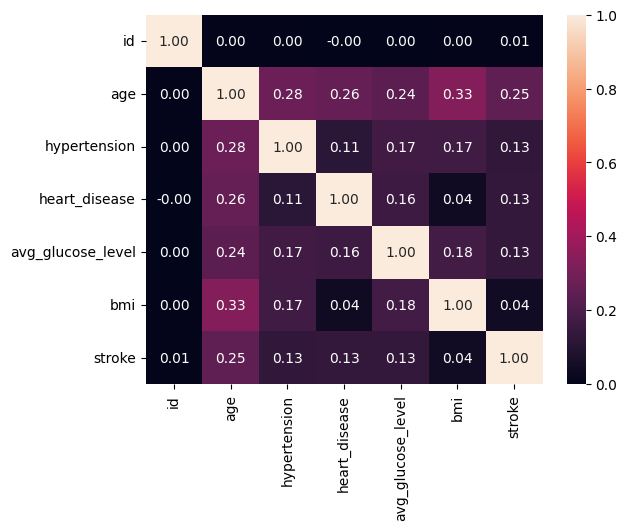

In [37]:
data=pd.read_csv('./healthcare-dataset-stroke-data.csv')
dataplot = sns.heatmap(data.corr(), annot=True, fmt=".2f")